In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pint
import plotly.express as px
import plotly.graph_objects as go
import xarray as xr
from dask.distributed import Client
from seapopym.configuration.no_transport.parameter import ForcingParameters
from seapopym.configuration.parameters.parameter_forcing import ForcingUnit
from seapopym.standard.units import StandardUnitsLabels

from seapopym_optimization import Observation, constraint, wrapper
from seapopym_optimization.cost_function import NoTransportCostFunction
from seapopym_optimization.functional_groups import FunctionalGroupOptimizeNoTransport, Parameter
from seapopym_optimization.genetic_algorithm import GeneticAlgorithm, GeneticAlgorithmParameters
from seapopym_optimization.taylor_diagram import ModTaylorDiagram, generate_mod_taylor_diagram

xr.set_options(
    display_expand_attrs=False,
    display_expand_data_vars=False,
    display_expand_coords=False,
    display_expand_data=False,
)

In [2]:
path_to_forcing = "../../../1_data_processing/1_1_Forcing/1_optional_extract_barents_sea/Barents_sea_forcing.zarr"
path_to_obs = "../../../1_data_processing/1_1_Forcing/1_optional_extract_barents_sea/zoo_1987_1999.zarr"
export_file_name = "SeapoPym_BARENTS_climato_vgpm_opti_all_parameters_1_group"

In [3]:
LATITUDE = 72
LONGITUDE = 20
TIME_START = "1998-01-01"
TIME_END = "1999-12-01"

## Loading


### Forcing


In [4]:
forcing = xr.open_zarr(path_to_forcing)
forcing = forcing.sel(time=slice(TIME_START, TIME_END))
forcing["T"].attrs["units"] = StandardUnitsLabels.temperature.units
forcing.load()

<xarray.Dataset> Size: 34kB
Dimensions:              (depth: 1, latitude: 1, longitude: 1, time: 700)
Coordinates: (4)
Data variables: (5)
Attributes: (6)

### Epipelagic layer


In [5]:
epi_layer_depth = forcing["pelagic_layer_depth"].load()
epi_layer_depth = epi_layer_depth.resample(time="1D").mean()
epi_layer_depth.attrs["units"] = "meter"
epi_layer_depth = epi_layer_depth.pint.quantify()
epi_layer_depth

<xarray.DataArray 'pelagic_layer_depth' (latitude: 1, longitude: 1, time: 700)> Size: 6kB
[m] 300.7 301.5 302.4 303.4 304.4 305.1 ... 265.0 266.6 268.1 269.6 271.3 273.0
Coordinates: (3)
Attributes: (1)

<!-- ## Observed NPP -->


### Observations


In [6]:
with xr.set_options(keep_attrs=True):
    observations = xr.open_zarr(path_to_obs).load()
    # observations = observations.sel(latitude=LATITUDE, longitude=LONGITUDE, method="nearest")
    observations = observations.resample(time="1D").mean().dropna("time")
    observations = observations.pint.quantify().pint.to("mg/m^2").pint.dequantify()
    observations = (
        observations.mean("latitude")
        .expand_dims({"latitude": [LATITUDE]})
        .transpose("time", "latitude", "longitude", "layer")
    )
    observations.latitude.attrs = forcing.latitude.attrs
    # observations = observations * epi_layer_depth
    # observations = observations.drop_vars("depth")
observations

<xarray.Dataset> Size: 3kB
Dimensions:    (latitude: 1, time: 156, longitude: 1, layer: 1)
Coordinates: (4)
Data variables: (1)

Create structure for SeapoPym simulation.


In [7]:
forcing_parameters = ForcingParameters(
    temperature=ForcingUnit(forcing=forcing["T"], resolution=1 / 12, timestep=1),
    primary_production=ForcingUnit(forcing=forcing["npp"], resolution=1 / 12, timestep=1),
)

2025-01-22 11:13:27,330 :: Seapodym ::  WARNING ::
|	npp unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.



## Setup the parameters and the cost function


In [8]:
functional_groups = [
    FunctionalGroupOptimizeNoTransport(
        name="TOTAL",
        day_layer=0,
        night_layer=0,
        energy_coefficient=Parameter("TOTAL_energy_coefficient", 0.001, 0.4),
        tr_rate=Parameter("TOTAL_tr_rate", -0.3, -0.001),
        tr_max=Parameter("TOTAL_tr_max", 0, 50),
        inv_lambda_rate=Parameter("TOTAL_inv_lambda_rate", -0.3, -0.001),
        inv_lambda_max=Parameter("TOTAL_inv_lambda_max", 0, 500),
    ),
]
# [1, 1, 0.1668, 10.38, -0.11, 150, 0.15]

In [9]:
cost_function = NoTransportCostFunction(
    functional_groups=functional_groups,
    forcing_parameters=forcing_parameters,
    observations=[Observation(observations)],
)

Set the genetic algorithm meta parameters.


In [10]:
genetic_algo_parameters = GeneticAlgorithmParameters(
    MUTPB=0.1,
    INDPB=0.2,
    ETA=5,
    CXPB=0.8,
    NGEN=10,
    POP_SIZE=500,
    cost_function_weight=(-1,),
)

Add a constraint to limit the total of energy transfert coefficient to 100%.


In [11]:
# constraint_energy = constraint.ConstraintNoTransportEnergyCoefficient(
#     parameters_name=["D1N1_energy_coefficient", "D2N1_energy_coefficient"],
#     min_energy_coef_value=0,
#     max_energy_coef_value=1,
# )

Finaly, create the Genetic Algorithm.


In [12]:
client = Client()
genetic_algo = GeneticAlgorithm(
    cost_function=cost_function,
    parameter_genetic_algorithm=genetic_algo_parameters,
    # constraint=[constraint_energy],
    client=client,
)

And watch the magic on the Dask dashboard :


In [13]:
genetic_algo.client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 48.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50286,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 48.00 GiB
Comm: tcp://127.0.0.1:50298,Total threads: 3
Dashboard: http://127.0.0.1:50303/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:50289,


## Run the optimization


In [14]:
viewer = genetic_algo.optimize()

,mean,std,min,max,valid,from_previous_generation
generation,,,,,,
0,15.454652,28.813297,0.850723,187.581060,500,0.000
1,4.808499,8.286358,0.797787,84.067257,500,0.174
2,3.895970,9.686004,0.792769,145.973293,500,0.212
3,2.444722,3.933679,0.757859,64.130101,500,0.196
4,2.453271,5.547740,0.757859,83.591562,500,0.162
5,1.845701,2.286912,0.752470,26.227241,500,0.160
6,1.485646,1.513944,0.734034,21.402516,500,0.198
7,1.233709,1.185029,0.720545,16.785212,500,0.152
8,1.066836,0.860747,0.720545,11.686863,500,0.170


Generations: 100%|██████████| 10/10 [05:45<00:00, 34.59s/it]


## Plot the results


In [15]:
viewer.stats

,mean,std,min,max,valid,from_previous_generation
generation,,,,,,
0,15.454652,28.813297,0.850723,187.581060,500,0.000
1,4.808499,8.286358,0.797787,84.067257,500,0.174
2,3.895970,9.686004,0.792769,145.973293,500,0.212
3,2.444722,3.933679,0.757859,64.130101,500,0.196
4,2.453271,5.547740,0.757859,83.591562,500,0.162
5,1.845701,2.286912,0.752470,26.227241,500,0.160
6,1.485646,1.513944,0.734034,21.402516,500,0.198
7,1.233709,1.185029,0.720545,16.785212,500,0.152
8,1.066836,0.860747,0.720545,11.686863,500,0.170


In [16]:
viewer.hall_of_fame

TOTAL_energy_coefficient  TOTAL_tr_max  TOTAL_tr_rate  \
generation individual                                                          
7          247                         0.378295      4.059291      -0.282075   
6          328                         0.378295      9.081923      -0.282075   
7          294                         0.378295      9.081923      -0.258122   
9          56                          0.336650      1.620216      -0.202260   
           459                         0.334572      0.237719      -0.252234   
...                                         ...           ...            ...   
2          209                         0.337085     24.368708      -0.180479   
0          391                         0.365210      0.064533      -0.206417   
           120                         0.381052     25.726674      -0.257746   
           195                         0.363809     44.498705      -0.188462   
           281                         0.381114     26.645499      -0.086698   

                       TOTAL_inv_lambda_max  TOTAL_inv_lambda_rate     fitness  
generation individual                                                           
7          247                   161.338917              -0.298785    0.720545  
6          328                   161.338917              -0.298785    0.734034  
7          294                   161.338917              -0.298785    0.735049  
9          56                    160.876616              -0.281020    0.744762  
           459                   166.756144              -0.281020    0.745010  
...                                     ...                    ...         ...  
2          209                   382.532119              -0.005384  145.973293  
0          391                   415.638608              -0.043862  151.765519  
           120                   398.080198              -0.047336  153.533723  
           195                   439.269411              -0.027613  172.959115  
           281                   375.301933              -0.004259  187.581060  

[4180 rows x 6 columns]

In [17]:
viewer.fitness_evolution()

In [18]:
viewer.box_plot(3, nbest=1000)

In [19]:
viewer.parallel_coordinates(1000, unselected_opacity=0)

# Generate plots at each station


In [21]:
best_individual = cost_function.functional_groups.generate_matrix(viewer.hall_of_fame.iloc[0])
print(f"Best individual: {list(best_individual[0])}")

Best individual: [0.0, 0.0, 0.37829451128979735, 4.059291268408993, -0.2820749785305789, 161.33891728259303, -0.2987853163335571]


## Run simulation


In [23]:
model_print = wrapper.model_generator_no_transport(
    forcing_parameters=forcing_parameters,
    fg_parameters=wrapper.FunctionalGroupGeneratorNoTransport(parameters=best_individual, groups_name=["TOTAL"]),
)

model_print.run()

## Plot


### Taylor Diagram


Convert to pandas series.


In [33]:
biomass_pandas = (
    model_print.export_biomass()
    .pint.quantify()
    .pint.to("mg/meter^2")
    .pint.dequantify()
    .to_dataframe()
    .pivot_table(index="time", columns="functional_group", values="biomass")
)
observations_pandas = observations.pint.quantify().pint.to("mg/m2").pint.dequantify()
observations_night_pandas = (
    observations_pandas.night.dropna("time").to_dataframe().reset_index().set_index("time")["night"]
)
layer_pandas = epi_layer_depth.pint.dequantify().to_dataframe().reset_index().set_index("time")["pelagic_layer_depth"]

Then resample to month.


In [34]:
# monthly_obs_day = observations_day_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
# monthly_obs_day.index = monthly_obs_day.index.to_period("M").to_timestamp()

monthly_obs_night = observations_night_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_obs_night.index = monthly_obs_night.index.to_period("M").to_timestamp()

monthly_pred_d1n1 = biomass_pandas.iloc[:, 0].resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_pred_d1n1.index = monthly_pred_d1n1.index.to_period("M").to_timestamp()

# monthly_pred_d2n1 = biomass_pandas.iloc[:, 1].resample("ME").mean()[TIME_START:TIME_END].dropna()
# monthly_pred_d2n1.index = monthly_pred_d2n1.index.to_period("M").to_timestamp()

monthly_layer = layer_pandas.resample("ME").mean()[TIME_START:TIME_END].dropna()
monthly_layer.index = monthly_layer.index.to_period("M").to_timestamp()

In [36]:
fig = go.Figure(
    layout={
        "title": "SeapoPym Monthly Biomass during day (CAFE npp) and Observations : HOT station + all param. optimization + 2 groups",
        "xaxis": {"title": "Time"},
        "yaxis": {"title": "Biomass . Epipelagic layer depth (mg/m^2)"},
    }
)


# fig.add_trace(
#     go.Scatter(
#         x=monthly_obs_day.index,
#         y=monthly_obs_day,
#         fill=None,
#         mode="lines",
#         line={"color": "red", "width": 1},
#         name="Observations (day)",
#     )
# )

fig.add_trace(
    go.Scatter(
        x=monthly_obs_night.index,
        y=monthly_obs_night,
        # fill="tonexty",
        mode="lines",
        line={"color": "blue", "width": 2},
        name="Observations (night)",
    )
)
fig.add_trace(
    go.Scatter(
        x=monthly_pred_d1n1.index,
        y=monthly_pred_d1n1,
        fill=None,
        mode="lines",
        line={"color": "black"},
        name="Predictions D1N1",
    )
)
# fig.add_trace(
#     go.Scatter(
#         x=(monthly_pred_d1n1 + monthly_pred_d2n1).index,
#         y=(monthly_pred_d1n1 + monthly_pred_d2n1),
#         fill=None,
#         mode="lines",
#         line={"color": "black", "dash": "dash"},
#         name="Predictions D2N1",
#     )
# )
fig.add_trace(px.line(monthly_layer).data[0])
fig.update_traces(
    yaxis="y2",
    selector={"name": "pelagic_layer_depth"},
    line={"color": "green", "width": 1, "dash": "dash"},
)
fig.update_layout(yaxis2={"title": "Layer Depth (m)", "overlaying": "y", "side": "right"})

fig.show()

In [37]:
fig.write_html(f"Biomass_{export_file_name}.html")

correlation [0.9177531072281262]
norm STD [1.1087435727957806]
bias [-0.2640290961449851]
NRMSE [0.4406887701211237]
name ['Berants Sea - Total']


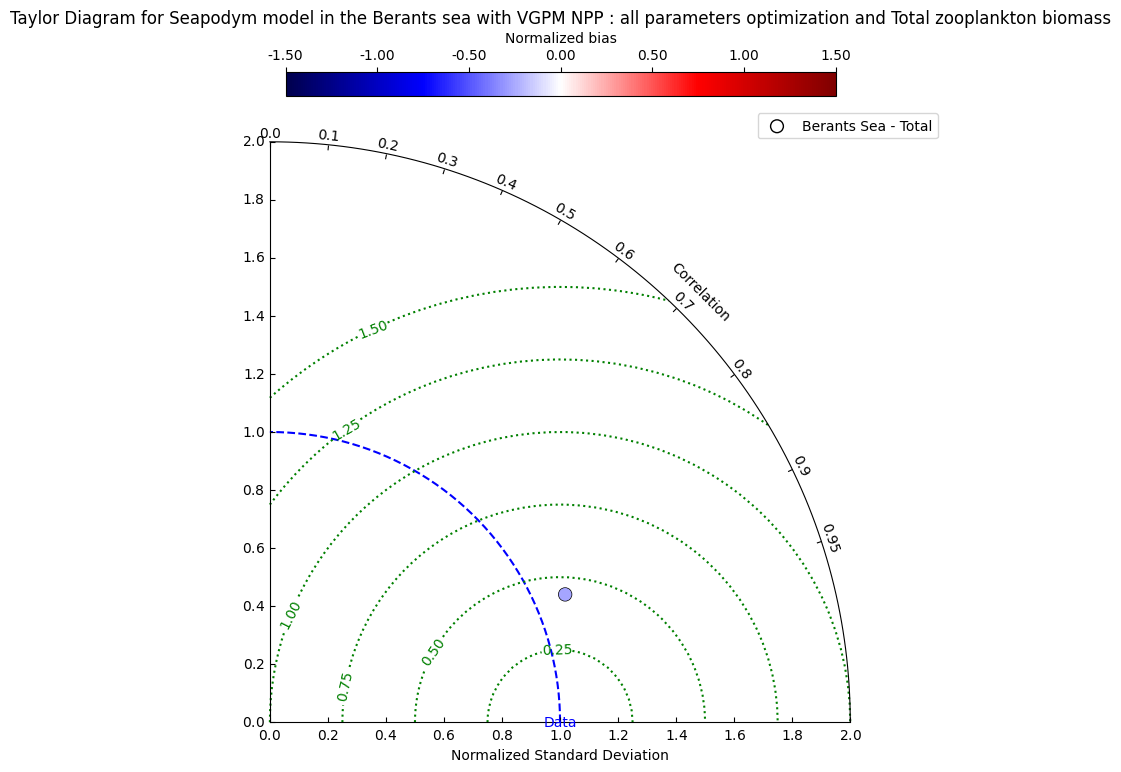

In [38]:
diagram = ModTaylorDiagram()

all_model = [monthly_pred_d1n1]
all_obs = [monthly_obs_night]

all_names = ["Berants Sea - Total"]

for model, obs, name in zip(all_model, all_obs, all_names):
    diagram = generate_mod_taylor_diagram(diagram, obs=obs, model=model[obs.index], name=name)
diagram.plot()
plt.title(
    "Taylor Diagram for Seapodym model in the Berants sea with VGPM NPP : all parameters optimization and Total zooplankton biomass"
)

# export the figure
plt.savefig(f"Taylor_{export_file_name}.png")

plt.show()

In [39]:
diagram.get_stats().to_csv(f"Stats_{export_file_name}.csv", index=False)
diagram.get_stats()

,name,correlation_coefficient,normalized_standard_deviation,bias,normalized_root_mean_square_deviation
0,Berants Sea - Total,0.917753,1.108744,-0.264029,0.440689
